In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.optimize import minimize
from nodepy import rk
from IPython.display import clear_output
import sys




rk4 = rk.loadRKM('RK44').__num__()
ssp33 = rk.loadRKM('SSP33').__num__()
ssp22 = rk.loadRKM('SSP22').__num__()
bs5 = rk.loadRKM('BS5').__num__()

A22= np.array([[0,0],[0.5,0]])
b22= np.array([0,1])
rk2= rk.ExplicitRungeKuttaMethod(A22,b22)

A31= np.array([[0,0,0], [2/3,0,0], [1/3,1/3,0]])
b31= np.array([1/4, 0, 3/4])
rk31=  rk.ExplicitRungeKuttaMethod(A31,b31)
rk31.bhat= np.array([1/4, 3/8, 3/8])

fehlberg45 = rk.loadRKM("Fehlberg45").__num__() # Fifth order 

#base_methods= [ssp2, ssp3, rk4, bs5]
base_methods= [rk2, rk31, rk4, bs5]

#base_method_labels= ["SSPRK(2,2)","SSPRK(3,3)", "RK(4,4)", "BSRK(8,5)"]
base_method_labels= ["RK(2,2)","RK(3,3)", "RK(4,4)", "BSRK(8,5)"]

types= ["RK", "RRK", "RFRK"]

k= np.zeros((4,8))
k[0,:]= [1,-1,0,0,0,0,0,0]
k[1,:]= [2,-1,-1,0,0,0,0,0]
k[2,:]= [1,2,-2,-1,0,0,0,0]
k[3,:]= [2,-1,-1,0,0,0,0,0]

print(bs5.c)
## ssp2:



[0.         0.16666667 0.22222222 0.42857143 0.66666667 0.75
 1.         1.        ]


In [2]:
colors = ['#E69F00', '#56B4E9', '#009E73', '#0072B2', '#D55E00', '#CC79A7', '#F0E442']
#linestyles = ['-', '--', '-.', ':', "-", "--", "-."]
linestyles = ['-', '--', '-.', ':', (5, (10, 3)),(0, (3, 1, 1, 1))]
markers = ['o','D','X','s','v',"P"]

In [3]:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 20}

import matplotlib
matplotlib.rc('font', **font)

#plt.rc("text", usetex=True)
plt.rc("legend", fontsize="medium", fancybox=True, framealpha=0.5)

plt.rcParams["mathtext.fontset"] = "cm"

In [4]:
# Required functions for Euler's equation
# Definition of the RHS Function:
def f(u):
    # left and right values
    ul = np.zeros(np.size(u)+1)
    ul[1:] = u; ul[0] = u[-1]
    ur = np.zeros_like(ul)
    ur[:-1] = u; ur[-1] = u[0]
    # compute numerical fluxes
    #mu= 0.0001 # Dissipative
    mu= 0.0001
    #mu= 0
    
    fluxes = (ul * ul + ul * ur + ur * ur) /6 - mu*(ur-ul)
    # compute flux differences
    fluxdiff = -(fluxes[1:] - fluxes[:-1]) / dx
    return fluxdiff



def G_1(u):
    
    return 0.5*np.dot(u,u)

def dG_1(u):
    return u






def rgam(gamma,u,inc1,E1_old, est):
    gamma1 = gamma
    uprop = u + gamma1*inc1 
    E1 = G_1(uprop)

    return E1-E1_old - (gamma1+1)*est

def rgam_RF(eps,dt, u_tilde, search1, E1_old, est):
    
    
    uprop = u_tilde + dt* eps* search1 
    E1 = G_1(uprop)

    return E1-E1_old - est


def proj_distance(k_0, s, F, dt, u_tilde, E1_old, est):

    no_inv = 1; eps0 = 0.1
    
    
    k_01= k_0.copy()
    

    search_01= sum([k_01[i]*F[i] for i in range(s)])/np.linalg.norm(sum([k_01[i]*F[i,:] for i in range(s)]))
    #search_02= sum([k_02[i]*F[i] for i in range(s)])/np.linalg.norm(sum([k_02[i]*F[i,:] for i in range(s)]))

    eps, info, ier, mesg = fsolve(rgam_RF,eps0,args=(dt, u_tilde,search_01,E1_old, est),full_output=True)
    #print('mesg: ', mesg)
 

    distance= np.linalg.norm(dt*eps* search_01 )
    #print('distance_opt: ', distance)
    #print('k_1 optimized: ', k_01)
    #print('k_2 optimized: ', k_02)
    return distance

    

def Angle_between(v1, v2):
    
    V1= v1/np.linalg.norm(v1)


    
    V2= v2/np.linalg.norm(v2)

    return (180/np.pi)* np.arccos(np.dot(V1, V2))



In [5]:
def project_direction(u, F):
    s= np.size(F[:, 0])
    n= np.size(F[0, :])

    Normals= np.zeros((1, n))




    for i in range(s):
        normal = F[i , :].copy()
        
        for j in range(np.size( Normals[:, 0] )):

            normal -= np.dot(normal, Normals[j, :])* Normals[j, :]

        
        
        if np.linalg.norm(normal) > 1.e-5:
            normal= normal / np.linalg.norm(normal)

            Normals= np.append(Normals, np.reshape(normal.copy(), (1,len(normal))), axis=0)
            

    
    
 
    
    u_projected= np.zeros(n)
    for i in range(np.size( Normals[:, 0] )):
        #print('dot(u, Normals): ',np.dot(u, Normals[i, :]))
        u_projected += np.dot(u, Normals[i, :])* Normals[i, :]

    #print('optimized deg:', (180/np.pi)* np.arccos(np.dot(u, u_projected)/ (np.linalg.norm(u)* np.linalg.norm(u_projected))))

    return u_projected
    

Definition of the general integration function

# Base RK

In [6]:
# Compute solution with baseline RK methods
def compute_sol_without_relaxation(Mthdname,rkm, dt, f, T, u0,t0): 
    tt = np.zeros(1) 
    t = t0; tt[0] = t
    uu = np.zeros((1,np.size(u0))) 
    uu[0,:] = u0.copy()
    
    s = len(rkm)
    y = np.zeros((s,len(u0))) 
    F = np.zeros((s,len(u0))) 
    steps = 0
    
    while t < T and not np.isclose(t, T):
        clear_output(wait=True)
        if t + dt > T:
            dt = T - t
        for i in range(s):
            y[i,:] = uu[-1].copy()
            for j in range(i):
                y[i,:] += dt*rkm.A[i,j]*F[j,:]
            F[i,:] = f(y[i,:])
        inc = dt*sum([rkm.b[i]*F[i] for i in range(s)])    
        unew = uu[-1]+inc; t+= dt
        tt = np.append(tt, t)
        steps +=1
        uu = np.append(uu, np.reshape(unew.copy(), (1,len(unew))), axis=0)  
        #print("Method = Baseline %s: Step number = %d (time = %1.2f)"%(Mthdname,steps,tt[-1]))
    return tt, uu

# RRK

In [7]:
def compute_relaxation(Mthdname,rkm, dt, f, T, u0, t0):
    tt = np.zeros(1) 
    t = t0; tt[0] = t
    uu = np.zeros((1,np.size(u0))) 
    uu[0,:] = u0.copy()
    
    s = len(rkm)
    y = np.zeros((s,len(u0))) 
    F = np.zeros((s,len(u0))) 
    
    Gamma = np.array([]); 
    Gamma = np.append(Gamma, 0)
    
    no_inv = 1; gamma0 = 1
    Inv1_change= np.array([]); 

    proj_length= []

    proj_angle= []

   
    
    errs = 0; steps = 0

    n=0 #test

    
    
    while t < T and not np.isclose(t, T):
    #while t < T and not n > 300 and not np.isclose(t, T):

        n+=1 #test
        clear_output(wait=True)
        if t + dt > T:
            dt = T - t
        for i in range(s):
            y[i,:] = uu[-1].copy()
            for j in range(i):
                y[i,:] += dt*rkm.A[i,j]*F[j,:]
            F[i,:] = f(y[i,:])
            
        inc1 = dt*sum([rkm.b[i]*F[i] for i in range(s)])

        est= dt* sum(rkm.b[i]*np.dot(y[i], F[i]) for i in range(s) )
        print('est: ', est)
       
        
        wr_unew = uu[-1] + inc1; E1_old = G_1(uu[-1]) 
        
        gamma, info, ier, mesg = fsolve(rgam,gamma0,args=(wr_unew,inc1,E1_old, est),full_output=True)

       
        print('gamma: ',gamma)

        
        

        
    
        
        

        numer = 2 * sum(rkm.b[i] * rkm.A[i, j] * np.dot(F[i], F[j]) \
                            for i in range(s) for j in range(s))
        
        denom = sum(rkm.b[i] * rkm.b[j] * np.dot(F[i], F[j]) for i in range(s) for j in range(s))

        print('numer: ', numer)
        print('denom: ', denom)

        gam = numer / denom -1
        print('1+gam: ', 1+gam)

        gamma1= gam

        



      



        
        
        unew =  wr_unew + gamma1*inc1 ; 
        
        t+=(1+gamma1)*dt
        #t+= dt # IDT - RRK
        
        E1_new= G_1(unew)

        if np.abs(E1_new- E1_old - (gamma1+1)*est)> 1.e-13  :
            print('ier: ', ier)
            print('Error RRK Method: Invariant(s) are not preserved  ')
            print('G_1(u) - G_1(u0)- (gamma + 1)est: ', E1_new- E1_old - (gamma1+1)*est)

            sys.exit(1)

        
       
        tt = np.append(tt, t)
        steps += 1
        uu = np.append(uu, np.reshape(unew.copy(), (1,len(unew))), axis=0) 
        Gamma = np.append(Gamma, gamma1);

        Inv1_change= np.append(Inv1_change, E1_new-E1_old) ; 

        proj_length= np.append(proj_length, np.linalg.norm(gamma1*inc1 ))

        proj_angle= np.append(proj_angle, Angle_between(gamma1*inc1 , dG_1(wr_unew)) )
        
        
        #print("Method = Relaxation %s: At step number = %d (time = %1.2f), integer flag = %d and E1-E1_old = %f \n"%(Mthdname,steps,tt[-1],ier,E1_new-E1_old))

    return tt, uu, Gamma,  proj_length, proj_angle

# Quasi-Orthogonal Projection

In [8]:
def compute_sol_QO(Mthdname,rkm, dt, f, T, u0, t0):
    tt = np.zeros(1) 
    t = t0; tt[0] = t
    uu = np.zeros((1,np.size(u0))) 
    uu[0,:] = u0.copy()
    
    s = len(rkm)
    y = np.zeros((s,len(u0))) 
    F = np.zeros((s,len(u0))) 
    
    Eps1 = np.array([]); 
    Eps1 = np.append(Eps1, 0)
    
    no_inv = 1; eps0 = 1
    Inv1_change= np.array([]); 

    proj_length= []

    proj_angle= []

   
    
    errs = 0; steps = 0

    n=0 #test

    
    
    while t < T and not np.isclose(t, T):
    #while t < T and not n >= 1 and not np.isclose(t, T):

        n+=1 #test
        clear_output(wait=True)
        if t + dt > T:
            dt = T - t
        for i in range(s):
            y[i,:] = uu[-1].copy()
            for j in range(i):
                y[i,:] += dt*rkm.A[i,j]*F[j,:]
            F[i,:] = f(y[i,:])
            
        inc1 = dt*sum([rkm.b[i]*F[i] for i in range(s)])

        est= dt* sum(rkm.b[i]*np.dot(y[i], F[i]) for i in range(s) )
        print('est: ', est)
       
        
        wr_unew = uu[-1] + inc1; 
        E1_old = G_1(uu[-1]) 


        search = project_direction (dG_1(wr_unew), F) # projects dG_1(wr_unew) to the space created by stage derivative vectors
        if np.linalg.norm(search) < 1.e-5:
            print('Search close to zero')

        search= search /np.linalg.norm(search)

        #search = inc1 - dt* F[0]
        #search= search /np.linalg.norm(search)

        #print('F0 deg:', (180/np.pi)* np.arccos(np.dot(wr_unew, search)/ (np.linalg.norm(wr_unew)* np.linalg.norm(search))))

        
            


        
        
        eps, info, ier, mesg = fsolve(rgam_RF,eps0,args=(dt, wr_unew,search,E1_old, est),full_output=True)
        
        #print('eps: ', eps)


        #print('search. ones', np.dot(search, np.ones(np.size(search))))
       

        
        

        
    
        

        
        
        unew =   wr_unew + dt*eps*search  ; t+=dt
        E1_new= G_1(unew)

        if np.abs(G_1(unew)- E1_old - est)> 1.e-13  :
            print('ier: ', ier)
            print('Error QO Method: Invariant(s) are not preserved  ')
            print('G_1(u) - G_1(u0)- est: ', G_1(unew) - E1_old - est)

            sys.exit(1)

       
        tt = np.append(tt, t)
        steps += 1
        uu = np.append(uu, np.reshape(unew.copy(), (1,len(unew))), axis=0) 
        Eps1 = np.append(Eps1, eps);

        Inv1_change= np.append(Inv1_change, E1_new-E1_old) ;

        proj_length= np.append(proj_length, np.linalg.norm(dt*eps*search))

        proj_angle= np.append(proj_angle, Angle_between(eps*search  , dG_1(wr_unew)) )
        
        print("Method = Orthogonal %s: At step number = %d (time = %1.2f), integer flag = %d and E1-E1_old = %f \n"%(Mthdname,steps,tt[-1],ier,E1_new-E1_old))

    return tt, uu, Eps1 , proj_length, proj_angle

# Example case 4

In [12]:

N = 50

x, dx = np.linspace(-1, 1, N, endpoint=False, retstep=True)
x = x + 0.5*dx # x are the mean values of each cell
u0 = np.exp(-30*x**2) 

u=u0

# RK 

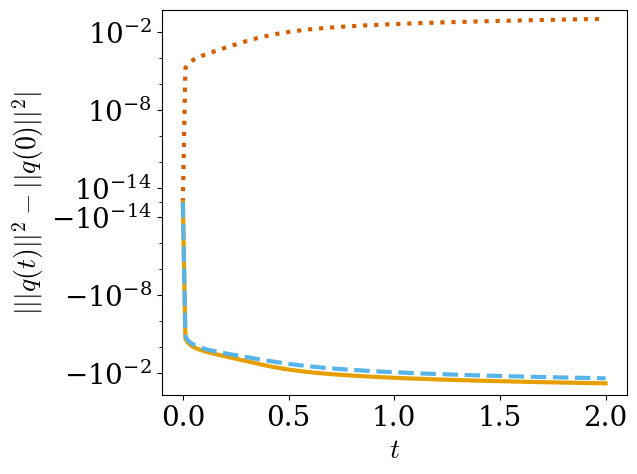

<Figure size 640x480 with 0 Axes>

In [13]:
dt= 0.3* dx
t_final= 2


linestyles = [':','-', '--',  '-.', (5, (10, 3)),(0, (3, 1, 1, 1))]

#colors = ['#E69F00', '#56B4E9', '#009E73', '#0072B2', '#D55E00', '#CC79A7', '#F0E442']
colors = ['#D55E00','#E69F00', '#56B4E9', '#CC79A7', '#F0E442']
#base_methods= [rk31, rk4, bs5]


#base_methods= [ssp22, rk4, fehlberg45]
base_methods= [ssp22, ssp33, fehlberg45]
base_method_labels= ["SSPRK(2,2)","SSPRK(3,3)", "Fehlberg(6,5)"]


fig=plt.figure(figsize=(6,5))
for b,base in enumerate(base_methods):

    
    tt, uu= compute_sol_without_relaxation("rk",base, dt, f, t_final, u0,t0=0)
    
    E= np.zeros_like(tt)
    for i in range(len(tt)):
        E[i]= np.dot(uu[i, :], uu[i, :])
        

    
    plt.plot(tt, (E-E[0]), color=colors[b] ,linestyle=linestyles[b],lw=3, label=base_method_labels[b])
    
plt.xlabel("$t$")
plt.ylabel("$|||q(t)||^2- ||q(0)||^2|$")
#plt.title('Standard RK methods' , fontsize= 18)



plt.ylim(-0.5, 0.5)
plt.yscale("symlog", linthresh=1.e-14)

plt.yticks([-1.e-2, -1.e-8, -1.e-14, 1.e-14, 1.e-8, 1.e-2])

ax = plt.gca()
#plt.savefig("Figures/Burgers_dissip_evol_RK.png",bbox_inches="tight")


plt.figure()
handles, labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels, loc="center", ncol=3)
#plt.savefig("./Figures/Burgers_dissip_evol_legend.png",bbox_inches="tight")


plt.show()  






# Quasi-Orthogonal

est:  -7.389684184019276e-05
Method = Orthogonal QO: At step number = 167 (time = 2.00), integer flag = 5 and E1-E1_old = -0.000074 



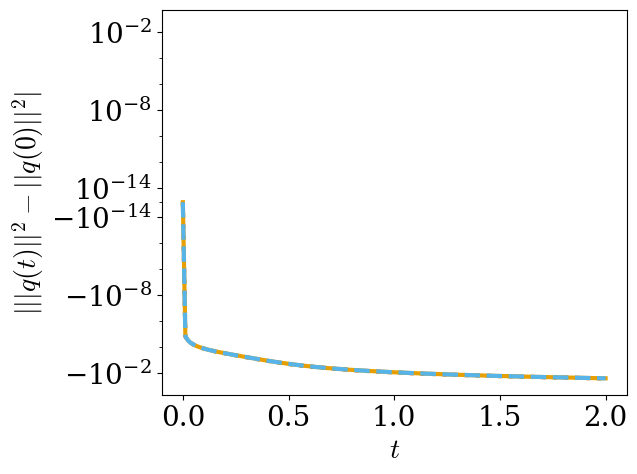

In [14]:
dt= 0.3* dx
t_final= 2


fig=plt.figure(figsize=(6,5))
for b,base in enumerate(base_methods):
    
    
    
    tt, uu, Eps, Inv_change, proj_angle= compute_sol_QO("QO",base, dt, f, t_final, u0,t0=0)
    
    E= np.zeros_like(tt)
    for i in range(len(tt)):
        E[i]= np.dot(uu[i, :], uu[i, :])
        
    
    plt.plot(tt, (E-E[0]), color=colors[b] ,linestyle=linestyles[b],lw=3, label=base_method_labels[b])



plt.xlabel("$t$")
plt.ylabel("$|||q(t)||^2- ||q(0)||^2|$")
#plt.ylabel("Energy Change")
#plt.title('Relaxation-RK methods' , fontsize= 18)


plt.ylim(-0.5, 0.5)
plt.yscale("symlog", linthresh=1.e-14)
plt.yticks([-1.e-2, -1.e-8, -1.e-14, 1.e-14, 1.e-8, 1.e-2])


#plt.savefig("Figures/Burgers_dissip_evol_QO.png",bbox_inches="tight")


plt.show() 

# Convergence Quasi-Orthogonal

est:  -1.4318841149737884e-07
Method = Orthogonal QO-RK: At step number = 1067 (time = 0.20), integer flag = 5 and E1-E1_old = -0.000000 



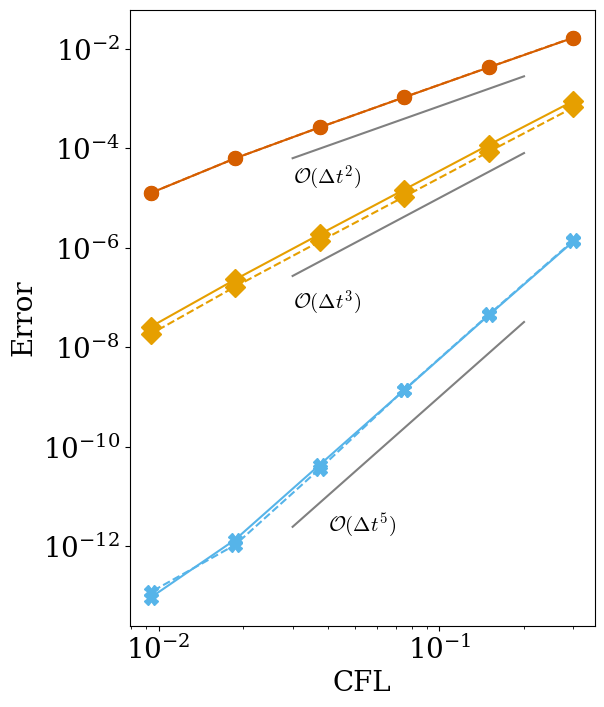

<Figure size 640x480 with 0 Axes>

In [15]:
cfls = 0.3 *0.5**np.arange(7)

linestyles = [':','-', '--',  '-.', (5, (10, 3)),(0, (3, 1, 1, 1))]

colors = ['#D55E00','#E69F00', '#56B4E9', '#CC79A7', '#F0E442']


base_methods= [ssp22, ssp33, fehlberg45]
base_method_labels= ["SSPRK(2,2)","SSPRK(3,3)", "Fehlberg(6,5)"]




t_final=0.2



plt.figure(figsize=(6,8))
#calculating the solutions

rk_errors= np.zeros((len(base_methods), cfls.size))

for b,base in enumerate(base_methods):
    
    sols_rk= []
    for cfl in cfls:
        
        dt= cfl*dx

        tt, uu= compute_sol_without_relaxation("rk",base, dt, f, t_final, u0,t0=0)
        sols_rk.append(uu[-1, :])
            
   
    ref = sols_rk[-1]
    
    for i in range(len(sols_rk)):
        rk_errors[b, i]= np.sum(np.abs(ref - sols_rk[i]))
        
        #rk_errors.append(np.sum(np.abs(ref - sols_rk[i])))
       


    plt.loglog(cfls[:-1], rk_errors[b, :-1], linestyle='-',color=colors[b],marker=markers[b],markersize=10, label=base_method_labels[b] )

 


# -------------------------------------------------------------

qo_errors= np.zeros((len(base_methods), cfls.size))

for b,base in enumerate(base_methods):
    
    sols_qo= []
    for cfl in cfls:
        
        dt= cfl*dx

        tt_qo, uu_qo, Eps, Inv_change, inv_angle= compute_sol_QO("QO-RK",base, dt, f, t_final, u0,t0=0)

        sols_qo.append(uu_qo[-1, :])
        
            
  
    ref = sols_qo[-1]
    for i in range(len(sols_qo)):
        qo_errors[b, i]= np.sum(np.abs(ref - sols_qo[i]))

    plt.loglog(cfls[:-1], qo_errors[b, :-1], linestyle='--',color=colors[b],marker=markers[b],markersize=10, label=None )


cfl_ind= np.array([0.03, 0.2])
plt.loglog(cfl_ind,0.07* cfl_ind**2, color= 'gray')
plt.annotate(r"$\mathcal{O}(\Delta t^2)$", (3.0e-2, 2.0e-5), color="k", fontsize=15)

plt.loglog(cfl_ind,0.01* cfl_ind**3, color= 'gray')
plt.annotate(r"$\mathcal{O}(\Delta t^3)$", (3.0e-2, 6.0e-8), color="k", fontsize=15)

plt.loglog(cfl_ind,0.0001* cfl_ind**5, color= 'gray')
plt.annotate(r"$\mathcal{O}(\Delta t^5)$", (4.0e-2, 2.0e-12), color="k", fontsize=15)


plt.xlabel("CFL")
plt.ylabel('Error')




#plt.savefig("Figures/Burgers_dissip_convergence_QO_RK.png",bbox_inches="tight")


ax = plt.gca()
plt.figure()
handles, labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels, loc="center", ncol=4)
#plt.savefig("./Figures/Burgers_dissip_convergence_legend.png",bbox_inches="tight")


plt.show()